# COMP5046 Assignment 1
*Make sure you change the file name with your unikey.*

NDES8735 - Nirav Desai

# Readme
*If there is something to be noted for the user, please mention here.* 

*If you are planning to implement a program with Object Oriented Programming style*

***Visualising the comparison of different results is a good way to justify your decision.***

# 1 - Data Preprocessing

## 1.1. Download Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import pandas as pd
import torch.nn.functional as F
import re
import nltk

from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as sw

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

save_path = '/content/drive/My Drive/COMP5046/assign_1/'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1vF3FqgBC1Y-RPefeVmY8zetdZG1jmHzT'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_train.csv')

id = '1XhaV8YMuQeSwozQww8PeyiWMJfia13G6'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_test.csv')

df_train = pd.read_csv("imdb_train.csv")
df_test = pd.read_csv("imdb_test.csv")

reviews_train = df_train['review'].tolist()
sentiments_train = df_train['sentiment'].tolist()
reviews_test = df_test['review'].tolist()
sentiments_test = df_test['sentiment'].tolist()

print("Training set number:",len(reviews_train))
print("Testing set number:",len(reviews_test))

Training set number: 25000
Testing set number: 25000


In [0]:
# enable GPU here (cuda); or just CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1.2. Preprocess data

Following techniques are used for Data Preprocessing:
1. General cleaning ::
*   Casefolding - data was converted to lower case to reduce the vocabulary size. Words like 'Hello' and 'hello' will be treated in similar fashion.
*   Tags and URL removal - The data contained some html tags and urls. As such, they will not add any extra information to our sentiment analysis task and removed to reduce overall vocabulary size.
*   Special Character removal - During character embedding, it was noticed that there were number of special/non-english characters in the dataset. Since, our libraries (nltk etc) are based on English languge only, it was decided to remove these characters. There is a chance of information loss (change in meaning/word) becasue of that.
*   Expanda contractions - To make it easier for "stopword" removal step, all known cotractions (including **capitalised** ) were expanded. For example "Haven't" expanded to 'have not'.
*   Remove numbers and punctuations - Removed numbers and other punctuations that add noise to the dataset.

2. Tokenization :: chopping each review document into word sequence. Tokenization will further help in lemmatization, stopword removal to preprocess data.

3. Lemmetization :: Decided to use Lemmetization instead of stemming. Stemming can at times change the meaning of the word. Because our modeling is basic (only 1 window size for context), we can't rely on 1-window sized context for meaningful processing. Hence, decided to use only lemmatization instead of stemming.

4. Stopword removal :: Removed commonly occurring stopword using nltk library. stopwords are common repitive words that add extra noise to word processing. Perormed at the end to maximise commond word removal.

### Exploratory Data Analysis

Text(0, 0.5, 'Total Samples')

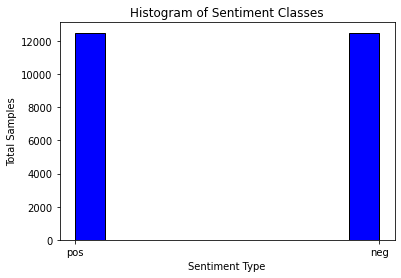

In [0]:
# Please comment your code
plt.hist(df_train['sentiment'], color = 'blue', edgecolor = 'black')
plt.title('Histogram of Sentiment Classes')
plt.xlabel('Sentiment Type')
plt.ylabel('Total Samples')

Based on above diagram, we can notice that our prediction is balanced binary sentiments.

### 1.2.1 General cleaning

In [0]:
# Removing punctuation, expanding contractions and removing <br /> tags

# Taken from Lab 5
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", 
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
cap_contraction_dict = {}

# Taken from Lab5
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

# Creating contractions dictionary with capitalised key value pairs.
# This will cater edge condition for some of the contractions like 'Haven't'
for k,v in contraction_dict.items():
  cap_contraction_dict[k.capitalize()] = v.capitalize()

contractions_dict = dict(contraction_dict)
contractions_dict.update(cap_contraction_dict)
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Expand contractions
def expand_contractions(s, contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, s)

# Remove punctuations
def remove_punctuation(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, ' ')
    return x

def preprocess_data(x):

    # Change to lower case
    x = x.lower()

    # Remove html tags such as <br />
    x_tag = re.sub(r'<[^<]+?>',' ',x)

    # Expand contractions
    x_contractions = expand_contractions(x_tag)

    # Remove site URLs
    x_url = re.sub(r'http\S+', ' ',x_contractions)

    # Remove special characters
    x_spl_chars = re.sub(r'[^A-Za-z0-9 ]+', ' ', x_url)

    # Remove numbers
    x_nums = re.sub(r'\d',' ',x_spl_chars)
    
    # Remove punctuations
    x_punctuate = remove_punctuation(x_nums)

    # Remove underscores '_'
    x_cleaned = re.sub(r'\_',' ',x_punctuate)   

    return x_cleaned

reviews_train_re = [preprocess_data(s) for s in reviews_train]
reviews_test_re = [preprocess_data(s) for s in reviews_test]

### 1.2.2 Tokenization

In [0]:
# Tokenization
tknzr = TweetTokenizer()

reviews_train_tk = [tknzr.tokenize(s) for s in reviews_train_re] 
reviews_test_tk = [tknzr.tokenize(s) for s in reviews_test_re]

### 1.2.3 Lemmatization

In [0]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatizer_list(seq_list):
  ls_lemmatized = []
  for tokens in seq_list:
    filtered_sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    ls_lemmatized.append(filtered_sentence)
  return ls_lemmatized

reviews_train_lm = lemmatizer_list(reviews_train_tk)
reviews_test_lm = lemmatizer_list(reviews_test_tk)

### 1.2.4 Stopword removal

In [0]:
#Stopword Removal
stop_words = sw.words()

def stopword_removal(seq_list):
  ls_no_stopword = []
  for tokens in seq_list:
    filtered_sentence = [w for w in tokens if not w in stop_words]
    ls_no_stopword.append(filtered_sentence)
  return ls_no_stopword

reviews_train_sw = stopword_removal(reviews_train_lm)
reviews_test_sw = stopword_removal(reviews_test_lm)

Save cleaned data for future use and saving reprocessing time.

In [0]:
# Save cleaned data
zippedList =  list(zip(reviews_train_sw, reviews_test_sw))
dfObj = pd.DataFrame(zippedList, columns = ['reviews_train_sw' , 'reviews_test_sw']) 

with open(save_path + 'cleaned_data.pkl', 'wb') as f:
    pickle.dump(dfObj, f)

# 2 - Model Implementation

## 2.1. Word Embeddings

**Model Selection**

*   Considering the size of the dataset, fasttext was ruled out. The n-grams used for fast text will need significantly higher resources that current colab environment.
*   Using word2vec skipgram model - Between CBOW and skipgram, I decided to choose skipgram just for a trial.

Each section will have explanation on approach taken. 

### 2.1.1. Data Preprocessing for Word Embeddings

*   Merged train and test data to create master list of all available words.
*   Padding - To make uniform input document length, we padded all documents based on maximum length of a document.
*   Create Skipgrams - Based on unique word and index, skipgrams were created for numeric (index) representation of target and context word. Window size of **more than 1** always crashes colab notebook and hence I kept it to minimum window size.

In [7]:
with open(save_path + 'cleaned_data.pkl', 'rb') as f:
    cleaned_df_obj = pickle.load(f)

cleaned_df_obj.head()

,reviews_train_sw,reviews_test_sw
0,"[enjoyed, movie, seen, andy, griffith, age, fe...","[course, going, think, wa, great, movie, recog..."
1,"[whole, doe, even, close, sum, part, problem, ...","[never, understood, type, spoof, movie, get, s..."
2,"[would, never, seen, independent, movie, wa, r...","[first, awful, rating, ever, imdb, could, thin..."
3,"[unpleasant, film, little, recommend, dolph, l...","[quite, bad, movie, oh, well, movie, least, la..."
4,"[wa, meant, parody, lotr, trilogy, wa, awful, ...","[horrific, make, french, movie, vie, rose, sce..."


In [0]:
reviews_train_clean = cleaned_df_obj['reviews_train_sw'].tolist()
reviews_test_clean = cleaned_df_obj['reviews_test_sw'].tolist()

In [9]:
# Merging training and test dataset for embedding training
total_reviews = []

[total_reviews.append(review) for review in reviews_train_clean]
[total_reviews.append(review) for review in reviews_test_clean]
print("Merged train and test reviews to process word embeddings")

Merged train and test reviews to process word embeddings


In [10]:
# Padding reviews to make equal length - pick maximum review length for padding
len_list = [len(s) for s in total_reviews]
seq_length = max(len_list)
print("Maximum length is : {}".format(seq_length))

def add_padding(corpus, seq_length):
    output = []
    for sentence in corpus:
        if len(sentence)>seq_length:
            output.append(sentence[:seq_length])
        else:
            for j in range(seq_length-len(sentence)):
                sentence.append("<PAD>")
            output.append(sentence)
    return output

total_reviews = add_padding(total_reviews,seq_length )
print("Each review is padded to length : {}".format( set( [len(s) for s in total_reviews])))

Maximum length is : 1385
Each review is padded to length : {1385}


In [0]:
# Coverting all words to unique word dictionary

word_sequence = []
for review in total_reviews:
  for word in review:
    word_sequence.append(word)

word_list = list(set(word_sequence))
word_list.sort()

# make dictionary so that we can be reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}
word_dict['<PAD>'] = 0

In [12]:
voc_size = len(word_list)
print("Vocab size is : {}, and total words are : {}".format(voc_size, len(word_sequence)))

Vocab size is : 89043, and total words are : 69250000


In [0]:
# Making window size 1 skip-gram
skip_grams = []
skip_gram_window = 1

for i in range(1, len(word_sequence) - 1):
    # (context, target) : ([target index - skip_gram_window, target index + skip_gram_window], target)
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - skip_gram_window]], word_dict[word_sequence[i + skip_gram_window]]]
    # skipgrams - (target, context[0]), (target, context[1])..
    for w in context:
        skip_grams.append([target, w])

In [0]:
len(skip_grams)
skip_grams[0:5]

[[52188, 24940], [52188, 69462], [69462, 52188], [69462, 2720], [2720, 69462]]

In [0]:
# dfObj = pd.DataFrame(skip_grams) 

# with open('/content/skip_grams.pkl', 'wb') as f:
#     pickle.dump(dfObj, f)

In [0]:
# prepare random batch from skip-gram - we have large number of skipgrams.
# Since we can't train model for all skipgrams,  we randomly select data
def prepare_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        input_temp = [0]*voc_size
        input_temp[data[i][0]] = 1
        random_inputs.append(input_temp)  # target
        random_labels.append(data[i][1])  # context word

    return np.array(random_inputs), np.array(random_labels)

### 2.1.2. Build Word Embeddings Model

Used following combination of parameter:

1.  Learning rate :: [0.1, 0.05] :: The loss was higher and unstable for learning rate of 0.1 and hence I lowered learning rate to 0.05.
2.  Batch size :: [200, 250, 300] :: Anything greater than 200 crashes the colab runtime and hence I kept to maximum acceptable value i.e. 200.
3.  Embedding size :: [50, 100] :: Between these  2 values, 100 gives a better results with reduced loss. However, there is performance impact. embedding size of 50 is much faster.
4. epochs :: [30, 50, 100] :: The results improve with higher epochs value. However, 50 epochs still gave low loss values. I decided to choose 50 as a trade off for perfomance and runtime.



In [0]:
# hyperparameters
learning_rate = 0.05
batch_size = 200
embedding_size = 100
epochs = 50

In [0]:
# Define model
class SkipGram(nn.Module):
    def __init__(self):
        super(SkipGram, self).__init__()
        self.linear1 = nn.Linear(voc_size, embedding_size, bias=False)
        self.linear2 = nn.Linear(embedding_size, voc_size, bias=False)

    def forward(self, x):
        hidden = self.linear1(x)
        out = self.linear2(hidden)
        return out

skip_gram_model = SkipGram()
criterion = nn.CrossEntropyLoss() 
optimiser = optim.Adam(skip_gram_model.parameters(), lr=learning_rate)

### 2.1.3. Train Word Embeddings Model

In [0]:
for epoch in range(epochs):

    inputs,labels = prepare_batch(skip_grams, batch_size)
    inputs_torch = torch.from_numpy(inputs).float()
    labels_torch = torch.from_numpy(labels)

    skip_gram_model.train()

    # 1. zero grad
    optimiser.zero_grad()

    # 2. forword propagation
    # 3. calculate loss
    # 4. back propagation
    outputs = skip_gram_model(inputs_torch)
    loss = criterion(outputs, labels_torch)
    loss.backward()
    optimiser.step()

    if epoch % 5 == 4: 
        print('Epoch: %d, loss: %.4f' %(epoch + 1, loss))

weight1 = skip_gram_model.linear1.weight 
trained_embeddings = weight1.detach().T.numpy()

Epoch: 5, loss: 7.2385
Epoch: 10, loss: 0.6258
Epoch: 15, loss: 0.7407
Epoch: 20, loss: 1.0992
Epoch: 25, loss: 0.8545
Epoch: 30, loss: 1.0687
Epoch: 35, loss: 0.9708
Epoch: 40, loss: 1.0944
Epoch: 45, loss: 1.3200
Epoch: 50, loss: 0.6171


### 2.1.4. Save Word Embeddings Model

In [0]:
torch.save(skip_gram_model, save_path + 'ndes8735_word.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SkipGram. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.1.5. Load Word Embeddings Model

In [0]:
skip_gram_word2Vec_model = torch.load(save_path + 'ndes8735_word.pt')
skip_gram_word2Vec_model.eval()

SkipGram(
  (linear1): Linear(in_features=89043, out_features=100, bias=False)
  (linear2): Linear(in_features=100, out_features=89043, bias=False)
)

## 2.2. Character Embeddings

### 2.2.1. Data Preprocessing for Character Embeddings

Used similar techniques as in Word Embedding preprocessing, but applied on character level. such as ::

*   Padding - To make uniform input word length, we padded all words based on maximum length of a word i.e. 72.
*   Based on unique characters and index, 

In [0]:
# Coverting all words to unique character dictionary

char_sequence = [list(w) for w in word_list]

# Adding character set for PAD place holder
[char_sequence.append(list(w)) for w in '<PAD>']

all_chars = []
for item in char_sequence:
  for char in item:
    all_chars.append(char)

char_list = list(set(all_chars))
char_list.sort()

# make dictionary so that we can be reference each index of unique word
char_dict = {w: i+1 for i, w in enumerate(char_list)}


In [0]:
max_char_len = max([len(word) for word in word_list])
print("Maximum word length to be used for padding : {}".format(max_char_len))
print("\nWords greater than length of 50...")
print([word for word in word_list if len(word) > 50])
print("\nCharacter dictionary")
print(char_dict)

Maximum word length to be used for padding : 72

Words greater than length of 50...
['blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah', 'caaaaaaaaaaaaaaaaaaaaaaligulaaaaaaaaaaaaaaaaaaaaaaa', 'isaboutaguylookingforthewomanwhosavedhisgrandpafromthenazis']

Character dictionary
{'<': 1, '>': 2, 'A': 3, 'B': 4, 'D': 5, 'P': 6, 'a': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'h': 14, 'i': 15, 'j': 16, 'k': 17, 'l': 18, 'm': 19, 'n': 20, 'o': 21, 'p': 22, 'q': 23, 'r': 24, 's': 25, 't': 26, 'u': 27, 'v': 28, 'w': 29, 'x': 30, 'y': 31, 'z': 32}


In [0]:

len_list = [len(s) for s in char_sequence]
seq_length = max(len_list)
print("Maximum word length is : {}".format(seq_length))

def add_padding_char(corpus, seq_length):
    output = []
    for sentence in corpus:
        if len(sentence)>seq_length:
            output.append(sentence[:seq_length])
        else:
            for j in range(seq_length-len(sentence)):
                sentence.append("$")
            output.append(sentence)
    return output

char_sequence_padded = add_padding_char(char_sequence,seq_length )
char_dict['$'] = 0
print("Each word is padded to length : {}".format( set( [len(s) for s in char_sequence_padded])))

Maximum word length is : 72
Each word is padded to length : {72}


In [0]:
# Prepare indexed character input
char_input_seq = []

for item in char_sequence_padded:
  char_input_seq.append([char_dict[c] for c in item])

In [0]:
print("A sample encoded word...")
print(char_input_seq[5678])

A sample encoded word...
[8, 7, 18, 19, 11, 10, 10, 15, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### 2.2.2. Build Character Embeddings Model

Used following combination of parameter:

1.  Learning rate :: 0.05
2.  Batch size :: [1024, 2048] :: Batch size of 2048 has significantly high processing time. Hence, I decided to keep 1024.
3. epochs :: [20,30,50] :: The processing time for each epoch is significantly high due to higher batch size. Between reducing batch size and epoch, I decided to keep minimum epochs of 20.

In [0]:
### Setting hyperparameters

learning_rate = 0.05
n_hidden = 50
total_epoch = 20

# Number of sequences for RNN = max word length
n_step = seq_length

# number of inputs
n_input = len(char_dict)
# number of classes
n_class = len(word_dict)
batch_size = 1024

In [0]:
# Define batching 
def make_batch(seq_data, word_embeddings):
    input_batch = []
    target_batch = []
    
    for i in range(word_embeddings.shape[0]):       
        # convert input to one-hot encoding.
        # if input is [3, 4, 4]:
        # [[ 0,  0,  0,  1,  0,  0,  0, ... 0]
        #  [ 0,  0,  0,  0,  1,  0,  0, ... 0]
        #  [ 0,  0,  0,  0,  1,  0,  0, ... 0]]
        input_batch.append(np.eye(n_input)[seq_data[i]])  
        target_batch.append(word_embeddings[i])

    return input_batch, target_batch

In [0]:
# Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True,bidirectional=True, dropout=0.3)
        self.linear = nn.Linear(n_hidden*2,n_class)
        self.linear_char = nn.Linear(n_class,n_hidden*2)


    def forward(self, sentence):
        #h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n,c_n) = self.lstm(sentence)
        #concat the last hidden state from two direction
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        z_char = self.linear_char(z)
        return z_char,hidden_out

### 2.1.4. Train Character Embeddings Model

In [0]:
# Load word embedding for training character model 
skip_gram_word2Vec_model = torch.load(save_path + 'ndes8735_word.pt')
trained_word_embeddings_torch = skip_gram_word2Vec_model.linear1.weight.data
trained_word_embeddings = trained_word_embeddings_torch.detach().T.numpy()

print("Shape of word embedding model : ")
print(trained_word_embeddings.shape)


Shape of word embedding model : 
(89043, 100)


In [0]:
# Move the model to GPU
net = Net()
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)


for epoch in range(total_epoch):  

    for i in range(0, trained_word_embeddings.shape[0], batch_size): 
        # Preparing input
        input_batch, target_batch = make_batch(char_input_seq[i: i+batch_size], trained_word_embeddings[i: i+batch_size])
        # Convert input into tensors and move them to GPU by uting tensor.to(device)
        input_batch_torch = torch.from_numpy(np.array(input_batch)).float()
        target_batch_torch = torch.from_numpy(np.array(target_batch))

        # Set the flag to training
        net.train()

        # forward + backward + optimize
        outputs,_ = net(input_batch_torch) 
        loss = criterion(outputs, target_batch_torch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Set the flag to evaluation, which will 'turn off' the dropout
    net.eval()
    outputs,_ = net(input_batch_torch) 
    
    # Evaluation loss
    loss = criterion(outputs, target_batch_torch)
    if epoch % 5 == 4: 
      print('Epoch: %d, loss: %.5f' %(epoch + 1, loss.item()))

print('Finished Training')


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 5, loss: 10.51139
Epoch: 10, loss: 1.71536
Epoch: 15, loss: 5.85946
Epoch: 20, loss: 2.76535
Finished Training


### 2.1.5. Save Character Embeddings Model

In [0]:
torch.save(net, save_path + 'ndes8735_character.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.1.6. Load Character Embeddings Model

In [0]:
char_embed_model = torch.load(save_path + 'ndes8735_character.pt')
char_embed_model.eval()

Net(
  (lstm): LSTM(33, 50, batch_first=True, dropout=0.3, bidirectional=True)
  (linear): Linear(in_features=100, out_features=89043, bias=True)
  (linear_char): Linear(in_features=89043, out_features=100, bias=True)
)

## 2.3. Sequence model

### 2.3.1. Apply/Import Word Embedding and Character Embedding Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [17]:
# Load word2vec embeddings
skip_gram_word2Vec_model = torch.load(save_path + 'ndes8735_word.pt')
skip_gram_word2Vec_model.eval()

SkipGram(
  (linear1): Linear(in_features=89043, out_features=100, bias=False)
  (linear2): Linear(in_features=100, out_features=89043, bias=False)
)

In [18]:
# Load char embeddings
char_embed_model = torch.load(save_path + 'ndes8735_character.pt')
char_embed_model.eval()

Net(
  (lstm): LSTM(33, 50, batch_first=True, dropout=0.3, bidirectional=True)
  (linear): Linear(in_features=100, out_features=89043, bias=True)
  (linear_char): Linear(in_features=89043, out_features=100, bias=True)
)

In [0]:
# Fetch trained embeddings from weights

trained_word_embeddings = skip_gram_word2Vec_model.linear1.weight.data.T
trained_char_embeddings = char_embed_model.linear_char.weight.data.T

In [20]:
# Merge embeddings

merged_embeddings_torch = torch.cat((trained_word_embeddings, trained_char_embeddings), 1)
print(merged_embeddings_torch.shape)

merged_embeddings = merged_embeddings_torch.detach().numpy().tolist()

torch.Size([89043, 200])


In [21]:
# Prepare training and test data
with open(save_path + 'cleaned_data.pkl', 'rb') as f:
    cleaned_df_obj = pickle.load(f)

cleaned_df_obj.head()

,reviews_train_sw,reviews_test_sw
0,"[enjoyed, movie, seen, andy, griffith, age, fe...","[course, going, think, wa, great, movie, recog..."
1,"[whole, doe, even, close, sum, part, problem, ...","[never, understood, type, spoof, movie, get, s..."
2,"[would, never, seen, independent, movie, wa, r...","[first, awful, rating, ever, imdb, could, thin..."
3,"[unpleasant, film, little, recommend, dolph, l...","[quite, bad, movie, oh, well, movie, least, la..."
4,"[wa, meant, parody, lotr, trilogy, wa, awful, ...","[horrific, make, french, movie, vie, rose, sce..."


In [22]:
# Prepare inputs
reviews_train_clean = cleaned_df_obj['reviews_train_sw'].tolist()
reviews_test_clean = cleaned_df_obj['reviews_test_sw'].tolist()
sentiments_train = df_train['sentiment'].tolist()
sentiments_test = df_test['sentiment'].tolist()

print("Training data size : data = {}, lables = {}".format(len(reviews_train_clean), len(sentiments_train)))
print('Word Embedding Shape : {}'.format(trained_word_embeddings.shape))
print('Character Embedding Shape : {}'.format(trained_char_embeddings.shape))

Training data size : data = 25000, lables = 25000
Word Embedding Shape : torch.Size([89043, 100])
Character Embedding Shape : torch.Size([89043, 100])


In [23]:
# encode output labels to class 0 and 1
from sklearn.preprocessing import LabelEncoder

labels = np.unique(sentiments_train)

lEnc = LabelEncoder()
lEnc.fit(labels)
label_train_n = lEnc.transform(sentiments_train)
label_test_n = lEnc.transform(sentiments_test)
numClass = len(labels)

print(labels)
print(lEnc.transform(labels))

['neg' 'pos']
[0 1]


In [24]:
# Pad the data same as word2vec model
len_list = [len(s) for s in total_reviews]
seq_length = max(len_list)
#print(seq_length)

data_train = add_padding(reviews_train_clean,seq_length )
data_test = add_padding(reviews_test_clean,seq_length )

print("Maximum review length after cleaning and preprocessing ...")
print(set( [len(s) for s in data_train]))
print(set( [len(s) for s in data_test]))

Maximum review length after cleaning and preprocessing ...
{1385}
{1385}


### 2.3.2. Build Sequence Model

Epochs - Tried with 100 and 150. There is no significant improvement after 100 epochs and hence I decided to keep it to minimum value.

In [0]:
# Hyper params
n_input = merged_embeddings_torch.shape[1]
n_hidden = 50
n_class = len(labels)
batch_size = 200
epochs = 100
learning_rate = 0.05

# Perfomance arrays
f1_score_list = []
accuracy_score_list = []
epoch_list = []

In [0]:
from sklearn.metrics import accuracy_score, f1_score


class Sentiment_Model(nn.Module):
    def __init__(self):
        super(Sentiment_Model, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True,bidirectional=True, dropout=0.3)
        self.linear = nn.Linear(n_hidden*2,n_class)

    def forward(self, sentence):
        
        #h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n,c_n) = self.lstm(sentence)
        #concat the last hidden state from two direction
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        log_output = F.log_softmax(z, dim=1)
        return log_output,hidden_out


In [0]:
# prepare random batch for sequence model
def prepare_batch_final(data, labels, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=True)

    for i in random_index:
        random_inputs.append(data[i])  # review
        random_labels.append(labels[i])  # sentiment

    return np.array(random_inputs), np.array(random_labels)

### 2.3.3. Train Sequence Model

In [0]:
# Get embeddings for each review and word
def get_merged_embeddings(reviews):
    m_embed_list = []
    for review in reviews:
        tmp = []
        for w in review:
            idx = word_dict[w]
            tmp.append(merged_embeddings[idx])
        m_embed_list.append(tmp)
    return m_embed_list

input_train = get_merged_embeddings(data_train)
input_test = get_merged_embeddings(data_test)

In [29]:
print('final input size in embeddings format words X embeddings : {} X {}'.format(len(input_train[0]),len(input_train[0][0])))

final input size in embeddings format words X embeddings : 1385 X 200


In [30]:
# Move the model to GPU
sentiment_model = Sentiment_Model().to(device)
# Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(sentiment_model.parameters(), lr=learning_rate)

for epoch in range(epochs):  
    
    # Preparing input
    input_batch, target_batch = prepare_batch_final(input_train,label_train_n, batch_size)
    # Convert input into tensors and move them to GPU by uting tensor.to(device)
    input_batch_torch = torch.from_numpy(np.array(input_batch)).float().to(device)
    target_batch_torch = torch.from_numpy(np.array(target_batch)).view(-1).to(device)

    # Set the flag to training
    sentiment_model.train()
    
    # forward + backward + optimize
    outputs,_ = sentiment_model(input_batch_torch) 
    loss = criterion(outputs, target_batch_torch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Set the flag to evaluation, which will 'turn off' the dropout
    sentiment_model.eval()
    outputs,_ = sentiment_model(input_batch_torch) 
    
    # Evaluation loss and accuracy calculation
    loss = criterion(outputs, target_batch_torch)
    if epoch % 5 == 4: 
        _, predicted = torch.max(outputs, 1)
        acc = accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
        f1 = f1_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())
        epoch_list.append(epoch+1)
        f1_score_list.append(f1)
        accuracy_score_list.append(acc)
        print('Epoch: %d, loss: %.5f, train_acc: %.2f, f1: %.2f' %(epoch + 1, loss.item(), acc, f1))

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 5, loss: 0.70885, train_acc: 0.53, f1: 0.63
Epoch: 10, loss: 0.66898, train_acc: 0.59, f1: 0.71
Epoch: 15, loss: 0.67946, train_acc: 0.54, f1: 0.60
Epoch: 20, loss: 0.67542, train_acc: 0.55, f1: 0.44
Epoch: 25, loss: 0.65790, train_acc: 0.56, f1: 0.64
Epoch: 30, loss: 0.66613, train_acc: 0.59, f1: 0.70
Epoch: 35, loss: 0.66814, train_acc: 0.62, f1: 0.37
Epoch: 40, loss: 0.68654, train_acc: 0.56, f1: 0.53
Epoch: 45, loss: 0.67632, train_acc: 0.60, f1: 0.66
Epoch: 50, loss: 0.64612, train_acc: 0.59, f1: 0.56
Epoch: 55, loss: 0.62592, train_acc: 0.64, f1: 0.68
Epoch: 60, loss: 0.64757, train_acc: 0.62, f1: 0.60
Epoch: 65, loss: 0.61988, train_acc: 0.69, f1: 0.69
Epoch: 70, loss: 0.65788, train_acc: 0.60, f1: 0.67
Epoch: 75, loss: 0.62831, train_acc: 0.64, f1: 0.69
Epoch: 80, loss: 0.57929, train_acc: 0.70, f1: 0.71
Epoch: 85, loss: 0.60993, train_acc: 0.64, f1: 0.71
Epoch: 90, loss: nan, train_acc: 0.54, f1: 0.00
Epoch: 95, loss: nan, train_acc: 0.50, f1: 0.00
Epoch: 100, loss: nan

### 2.3.4. Save Sequence Model

In [31]:
torch.save(sentiment_model, save_path + 'ndes8735_sequence.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Sentiment_Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.3.5. Load Sequence Model

In [32]:
sentiment_model_saved = torch.load(save_path + 'ndes8735_sequence.pt')
sentiment_model_saved.eval()

Sentiment_Model(
  (lstm): LSTM(200, 50, batch_first=True, dropout=0.3, bidirectional=True)
  (linear): Linear(in_features=100, out_features=2, bias=True)
)

# 3 - Evaluation

## 3.1. Performance Evaluation


You are required to provide the table with precision, recall, f1 of test set.

In [38]:
sentiment_model_saved = torch.load(save_path + 'ndes8735_sequence.pt')
sentiment_model_saved.eval()

Sentiment_Model(
  (lstm): LSTM(200, 50, batch_first=True, dropout=0.3, bidirectional=True)
  (linear): Linear(in_features=100, out_features=2, bias=True)
)

Only limited batch size can be tested. Anything more than 200 crashes the colab.

In [0]:
# Preparing input for 200 test samples
batch_size = 200

input_batch, target_batch = prepare_batch_final(input_test,label_test_n, batch_size)
# Convert input into tensors and move them to GPU by uting tensor.to(device)
input_batch_torch = torch.from_numpy(np.array(input_batch)).float().to(device)
target_batch_torch = torch.from_numpy(np.array(target_batch)).view(-1).to(device)

outputs,_ = sentiment_model_saved(input_batch_torch) 

In [40]:
_, predicted = torch.max(outputs.data, 1)

from sklearn.metrics import classification_report
print(classification_report(target_batch,predicted.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.75      0.63      0.68       107
           1       0.64      0.76      0.70        93

    accuracy                           0.69       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.70      0.69      0.69       200



## 3.2. Hyperparameter Testing
*You are required to draw a graph(y-axis: f1, x-axis: epoch) for test set and explain the optimal number of epochs based on the learning rate you have already chosen.*

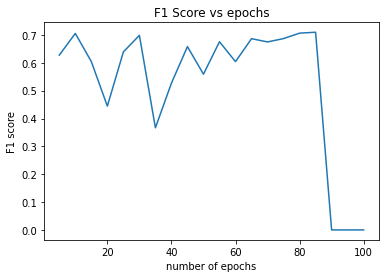

In [41]:
plt.plot(epoch_list, f1_score_list)
plt.title('F1 Score vs epochs')
plt.xlabel('number of epochs')
plt.ylabel('F1 score')
plt.show()

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed* 

In [0]:
# If you used OOP style, use this section